In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import filecmp

# Assignment 2: Bias in data

## Data Preprocessing

#### Read aggression data

In [2]:
agg_ant = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\aggression_annotations.tsv', sep='\t' )

#### Show records for aggression data

In [3]:
agg_ant.shape

(1365217, 4)

In [4]:
agg_ant_cmt = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\aggression_annotated_comments.tsv', sep='\t' )

In [5]:
agg_demo = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\aggression_worker_demographics.tsv', sep='\t' )

#### Join aggression_annotations with aggression_annotated_comments

In [6]:
agg_ant_agg_cmt = pd.merge(agg_ant, agg_ant_cmt, how='inner', on=['rev_id', 'rev_id'])

In [7]:
aggresive_df = pd.merge(agg_ant_agg_cmt,agg_demo, how= 'left',on=['worker_id','worker_id'])

#### Check if there is any null/nan values in worker_id

In [8]:
aggresive_df['worker_id'].isnull().values.any()

False

In [9]:
att_demo = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\attack_worker_demographics.tsv', sep='\t' )

#### Compare demographic data in attack and aggression, which shows they are exactly same files.

In [10]:
filecmp.cmp('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\attack_worker_demographics.tsv','C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\aggression_worker_demographics.tsv')

True

#### Read attack data

In [11]:
att_ant = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\attack_annotations.tsv', sep='\t' )

In [12]:
att_ant_cmt = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\attack_annotated_comments.tsv', sep='\t' )

In [13]:
att_demo = pd.read_csv('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\attack_worker_demographics.tsv', sep='\t' )

#### Join attack data 

In [14]:
att_ant_att_cmt = pd.merge(att_ant, att_ant_cmt, how='inner', on=['rev_id', 'rev_id'])

In [15]:
att_df = pd.merge(att_ant_att_cmt,att_demo, how= 'left',on=['worker_id','worker_id'])

#### Join  aggression data with attack data

In [16]:
agg_att_df = pd.merge(aggresive_df, att_df, how='inner', left_on=['rev_id','worker_id'], right_on = ['rev_id','worker_id'],suffixes=('', '_y'))

#### Drop duplicate columns

In [17]:
to_drop = [col for col in agg_att_df if col.endswith('_y')]

In [18]:
agg_att_df = agg_att_df.drop(columns=to_drop)

In [19]:
agg_att_df['aggression'].unique()

array([1., 0.])

#### Save data to local drive

In [20]:
agg_att_df.to_csv("C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\agg_att_data.csv")

## Analysis and Results

### How does the labelling behavior in the comments change over time?

#### Let's first look at records by each year. We observe that majority of the data is from 2006 to 2011, consisting of 71% of the total data, showing that there is a bias against other years.

In [21]:
agg_att_df.shape

(1365217, 19)

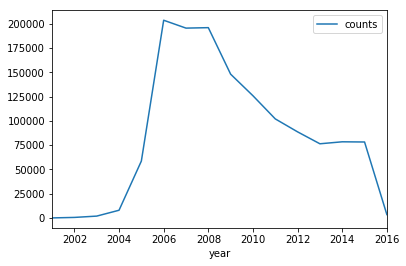

In [22]:
gx = (agg_att_df.groupby(['year']).size()).reset_index(name='counts').plot.line(x='year',y='counts')

In [23]:
(agg_att_df.groupby(['year']).size()/agg_att_df.shape[0]*100)

year
2001     0.005567
2002     0.042997
2003     0.142322
2004     0.584010
2005     4.292871
2006    14.910304
2007    14.316698
2008    14.351565
2009    10.844210
2010     9.216850
2011     7.471706
2012     6.493766
2013     5.595374
2014     5.744874
2015     5.730078
2016     0.256809
dtype: float64

#### We add personal attack identifiers and average aggression score to the visualization. From 2006 to 2011 where majority of the data is from, the data shows that the labelers tend to identify comments to contain more personal attack and more aggressive tone.

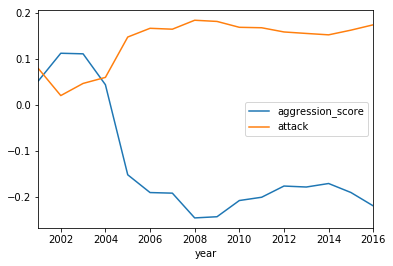

In [24]:
plot = agg_att_df.groupby(['year']).agg({"aggression_score":"mean","attack":"mean"}).plot()
plot.figure.savefig('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\Average Aggression & Attack Score by time.jpg')

### How does gender affect the labeling behavior in the comments over time?

#### Let's also take a look at the distribution of gender. We remove unidentified sex from the data. The graph clearly shows that there is a uneven gender distribution.

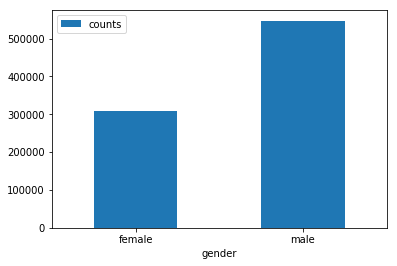

In [25]:
ax = agg_att_df[agg_att_df['gender'] != 'other'].groupby(['gender']).size().reset_index(name='counts').plot.bar(x='gender', y='counts', rot=0)

#### We calculate the percentage against gender and observe that male group accounts for most of the dataset.

In [26]:
gen_df = agg_att_df[agg_att_df['gender'] != 'other'].groupby(['gender']).size().reset_index(name='counts')
gen_df['percentage'] = gen_df['counts']/np.sum(gen_df['counts'])
gen_df

,gender,counts,percentage
0,female,308103,0.360173
1,male,547328,0.639827


#### Can the uneven distribution of gender affect the analysis? We analyze the labeling behavior across gender. The bar chart indicates that males are less likely to label comments as aggressive or to have personal attacks.

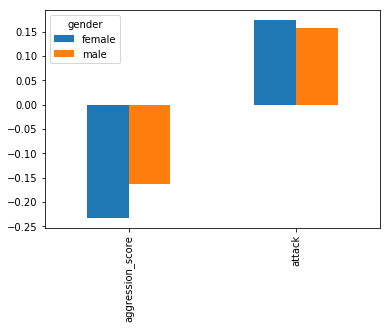

In [27]:
g_fig = agg_att_df[agg_att_df['gender'] != 'other'].groupby(['gender']).agg({"aggression_score":"mean","attack":"mean"}).T.plot.bar()
g_fig.figure.savefig('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\Average Aggression & Attack Score by Gender.jpg')

#### Let's dive in deeper into aggression labels dataset, limiting the gender to males and females. The result shows that regardless of time, the average aggession score that is labeled by males are significally lower comparing with females.

In [28]:
gen_yr_df = agg_att_df[(agg_att_df['gender'] != 'other') ].groupby(['year','gender']).agg({"aggression_score":"mean"})

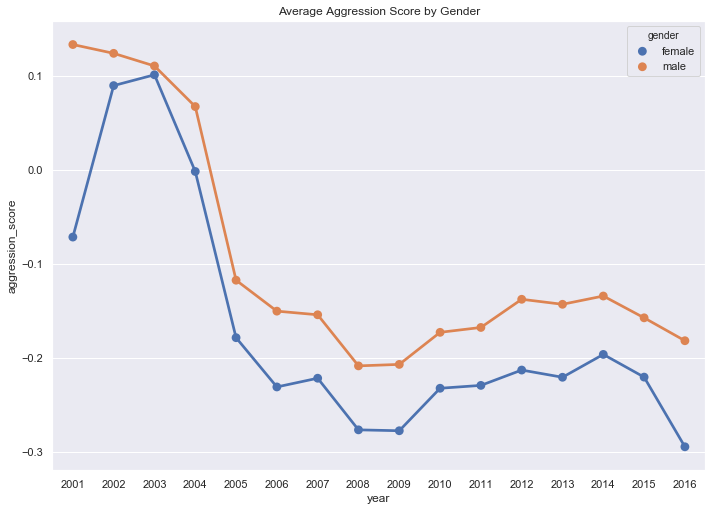

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.pointplot(data = gen_yr_df.reset_index(), 
              x='year', y='aggression_score', hue='gender').set_title("Average Aggression Score by Gender")
sns_plot.figure.savefig('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\Average Aggression Score by Gender.jpg')

#### Furthermore, we ran the same analysis for the attack score. The result also indicates that males are more likely to perceive a comment to be less hostile.

In [30]:
gen_yr_att_df = agg_att_df[(agg_att_df['gender'] != 'other') ].groupby(['year','gender']).agg({"attack":"mean"})

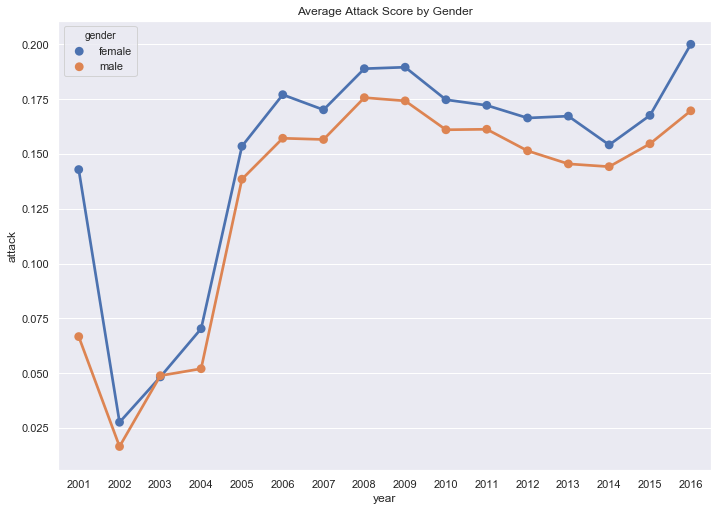

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot_att = sns.pointplot(data = gen_yr_att_df.reset_index(), 
              x='year', y='attack', hue='gender').set_title("Average Attack Score by Gender")

sns_plot_att.figure.savefig('C:\\Users\\jeffr\\Desktop\\MSDS\\Fall2020\\Data 512\\A2\\Average Attack Score by Gender.jpg')

## Potential implications
#### The dataset could produce prejudiced results because of the erroneous assumptions. From our analysis, the attack and aggression data favor responses from 2006 to 2011 and from male labelers who consider comments to discussions less aggressive and hostile over time. Such biases could result in failing to detect some of the toxic comments using the model. For example, when the model is given features to make predictions, the outcome could tend to conclude that comments are friendlier since the training data already reflects prejudices. Moreover, people's perspectives change over time and can be affected by historical events. The majority of the comments are retrieved from a certain time interval, causing other years to be underrepresented. This behavior could affect the outcome of the model since most of the labeling behavior is reflected only for those periods.


## Step 2: Discuss further implications

### a) Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

#### Behave! is a Google Chrome extension that allows users to filter out comments on social media based on their desired level of toxicity. The model trained on the Wikipedia corpus will work well in this matter because the majority of the data falls under the age group of 18 to 45, which is considered the most popular social media demographic today. Also, the education level within these groups does match the educational attainment of the U.S. population. I believe the application can reflect the model's use case.
 

### b) Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

#### Comment Slider provides users a way to sort comment streams based on the toxicity score of each comment. The application may fail to deliver its value because the training data set does not accurately represent gender. According to the aforementioned analysis, we notice that the male group is more likely to identify a comment containing a less aggressive tone than females. Hence, when the unseen comment is fed into the model, the algorithm will lose its objectivity in calculating the toxicity score.

### c) Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

#### We have to collect the training data that is representative of all groups. If applicable, perform any demographic weighting to the training data. We also need to do more complex EDA to slice and dice data at finer levels of detail, discovering existing prejudices or stereotypes, and frequently test and validate results to ensure the biases do not and should not occur in any stage of the process.